<a href="https://colab.research.google.com/github/KangChou/AI-Vision/blob/main/CLIP_explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CLIP Explainability**

In [1]:
"""
使用了 OpenAI 的 CLIP 模型，该模型能够同时理解图像和文本，并计算它们之间的相似性得分。通过预处理图像和文本，并在模型上进行推理，可以获取图像和文本之间的相似性分数。
随后，通过解释性分析技术，特别是使用了注意力机制，对模型的关注点进行可视化，生成了热图，展示了模型对输入图像和文本的关注程度。这使得用户可以更深入了解模型是如何理解和关联图像及文本的。
"""


!git clone https://github.com/hila-chefer/Transformer-MM-Explainability

import os
os.chdir(f'./Transformer-MM-Explainability')

!pip install einops
!pip install ftfy
!pip install captum

Cloning into 'Transformer-MM-Explainability'...
remote: Enumerating objects: 1477, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 1477 (delta 89), reused 65 (delta 65), pack-reused 1360
Receiving objects: 100% (1477/1477), 29.00 MiB | 15.87 MiB/s, done.
Resolving deltas: 100% (576/576), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.9 MB/s eta 0:00:00


# **CLIP**

In [2]:
# 导入PyTorch库
import torch

# 导入CLIP库中的clip模块
import CLIP.clip as clip

# 导入PIL库中的Image模块
from PIL import Image

# 导入NumPy库
import numpy as np

# 导入OpenCV库
import cv2

# 导入Matplotlib库中的pyplot模块
import matplotlib.pyplot as plt

# 从captum库中导入attr模块下的visualization子模块
from captum.attr import visualization


In [3]:
# 控制上下文扩展（考虑的注意力层的数量）
#@title Number of layers for image Transformer
# 图像Transformer的层数
start_layer =  -1 #@param {type:"number"}

#@title Number of layers for text Transformer
# 文本Transformer的层数
start_layer_text =  -1 #@param {type:"number"}


In [4]:
def interpret(image, texts, model, device, start_layer=start_layer, start_layer_text=start_layer_text):
    # 获取文本的批处理大小
    batch_size = texts.shape[0]

    # 复制图像以匹配文本的批处理大小
    images = image.repeat(batch_size, 1, 1, 1)

    # 使用模型进行推断，获取图像和文本的logits
    logits_per_image, logits_per_text = model(images, texts)

    # 计算图像对应的概率
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()

    # 为每个样本创建一个索引
    index = [i for i in range(batch_size)]

    # 创建一个独热编码的数组，用于计算梯度
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)

    # 计算梯度对输入图像的影响
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    # 获取图像注意力模块的列表
    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())

    # 如果未指定开始层，计算最后一层的索引
    if start_layer == -1:
        start_layer = len(image_attn_blocks) - 1

    # 获取图像注意力矩阵的大小
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]

    # 创建一个单位矩阵R，用于计算图像的相关性
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)

    # 遍历图像注意力模块进行反向传播和计算图像的相关性
    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)

    # 提取图像的相关性
    image_relevance = R[:, 0, 1:]

    # 获取文本注意力模块的列表
    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())

    # 如果未指定开始层，计算最后一层的索引
    if start_layer_text == -1:
        start_layer_text = len(text_attn_blocks) - 1

    # 获取文本注意力矩阵的大小
    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]

    # 创建一个单位矩阵R_text，用于计算文本的相关性
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)

    # 遍历文本注意力模块进行反向传播和计算文本的相关性
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R_text = R_text + torch.bmm(cam, R_text)

    # 提取文本的相关性
    text_relevance = R_text

    # 返回文本和图像的相关性
    return text_relevance, image_relevance


In [5]:
def show_image_relevance(image_relevance, image, orig_image):
    # 从掩码中创建热图
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    # 创建包含原始图像和相关性图的图表
    fig, axs = plt.subplots(1, 2)

    # 显示原始图像
    axs[0].imshow(orig_image)
    axs[0].axis('off')

    # 调整相关性图的维度，并插值到与原始图像相同的大小
    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()

    # 对图像和相关性进行归一化
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())

    # 创建并显示叠加了热图的图像
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs[1].imshow(vis)
    axs[1].axis('off')


In [6]:
from CLIP.clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
_tokenizer = _Tokenizer()

def show_heatmap_on_text(text, text_encoding, R_text):
  # 获取文本中[CLS]标记的索引
  CLS_idx = text_encoding.argmax(dim=-1)

  # 从R_text中提取与文本相关的重要性
  R_text = R_text[CLS_idx, 1:CLS_idx]

  # 对文本分数进行归一化
  text_scores = R_text / R_text.sum()
  text_scores = text_scores.flatten()

  # 打印归一化后的文本分数
  print(text_scores)

  # 使用CLIP的简单分词器对文本进行编码和解码
  text_tokens = _tokenizer.encode(text)
  text_tokens_decoded = [_tokenizer.decode([a]) for a in text_tokens]

  # 创建可视化数据记录，用于展示文本热图
  vis_data_records = [visualization.VisualizationDataRecord(text_scores, 0, 0, 0, 0, 0, text_tokens_decoded, 1)]

  # 调用captum库中的可视化工具，展示文本热图
  visualization.visualize_text(vis_data_records)


In [7]:
# CLIP模型字典，包含模型名称和对应的预训练权重下载链接
clip.clip._MODELS = {
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
    "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
    "ViT-L/14": "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt",
}


In [8]:
# 检查系统是否支持CUDA，选择相应的设备
device = "cuda" if torch.cuda.is_available() else "cpu"

# 使用CLIP库加载 ViT-B/32 模型
# 参数 jit=False 表示不启用即时编译
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)


100%|███████████████████████████████████████| 354M/354M [00:05<00:00, 68.9MiB/s]


In [9]:
# 定义颜色和样式的类
class color:
   PURPLE = '\033[95m'       # 紫色
   CYAN = '\033[96m'         # 青色
   DARKCYAN = '\033[36m'     # 深青色
   BLUE = '\033[94m'         # 蓝色
   GREEN = '\033[92m'        # 绿色
   YELLOW = '\033[93m'       # 黄色
   RED = '\033[91m'          # 红色
   BOLD = '\033[1m'          # 粗体
   UNDERLINE = '\033[4m'      # 下划线
   END = '\033[0m'            # 结束样式


tensor([0.0276, 0.0643, 0.0048, 0.1692, 0.7344], device='cuda:0',
       dtype=torch.float16)


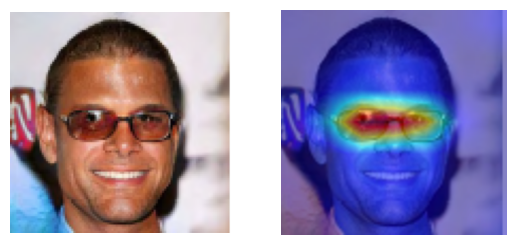

In [10]:
# 图像文件路径
img_path = "CLIP/glasses.png"

# 预处理图像并移动到指定设备
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

# 定义要分析的文本
texts = ["a man with eyeglasses"]

# 使用CLIP的分词函数对文本进行编码并移动到指定设备
text = clip.tokenize(texts).to(device)

# 进行模型解释性分析，获取文本和图像的相关性
R_text, R_image = interpret(model=model, image=img, texts=text, device=device)

# 获取文本的批处理大小
batch_size = text.shape[0]

# 遍历每个样本，显示文本和图像的相关性热图
for i in range(batch_size):
  # 显示文本相关性的热图
  show_heatmap_on_text(texts[i], text[i], R_text[i])

  # 显示图像相关性的热图
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))

  # 显示图像和文本的热图
  plt.show()


tensor([0.0028, 0.0356, 0.0324, 0.9292], device='cuda:0', dtype=torch.float16)


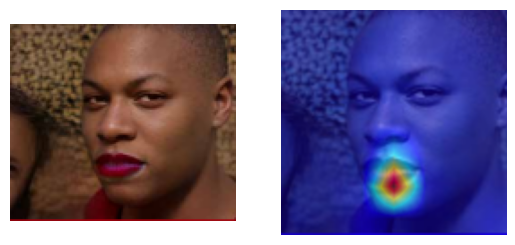

In [11]:
# 图像文件路径
img_path = "CLIP/lipstick.png"

# 预处理图像并移动到指定设备
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

# 定义要分析的文本
texts = ["a man with lipstick"]

# 使用CLIP的分词函数对文本进行编码并移动到指定设备
text = clip.tokenize(texts).to(device)

# 进行模型解释性分析，获取文本和图像的相关性
R_text, R_image = interpret(model=model, image=img, texts=text, device=device)

# 获取文本的批处理大小
batch_size = text.shape[0]

# 遍历每个样本，显示文本和图像的相关性热图
for i in range(batch_size):
  # 显示文本相关性的热图
  show_heatmap_on_text(texts[i], text[i], R_text[i])

  # 显示图像相关性的热图
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))

  # 显示图像和文本的热图
  plt.show()


tensor([0.0081, 0.0200, 0.1848, 0.0991, 0.0069, 0.0968, 0.5840],
       device='cuda:0', dtype=torch.float16)


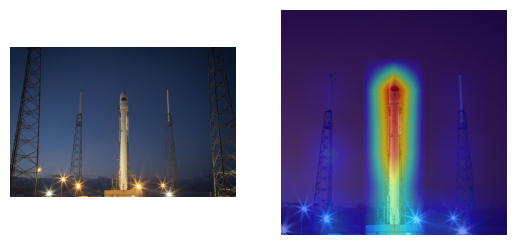

In [12]:
# 图像文件路径
img_path = "CLIP/rocket.jpg"

# 预处理图像并移动到指定设备
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

# 定义要分析的文本
texts = ["a rocket standing on a launchpad"]

# 使用CLIP的分词函数对文本进行编码并移动到指定设备
text = clip.tokenize(texts).to(device)

# 进行模型解释性分析，获取文本和图像的相关性
R_text, R_image = interpret(model=model, image=img, texts=text, device=device)

# 获取文本的批处理大小
batch_size = text.shape[0]

# 遍历每个样本，显示文本和图像的相关性热图
for i in range(batch_size):
  # 显示文本相关性的热图
  show_heatmap_on_text(texts[i], text[i], R_text[i])

  # 显示图像相关性的热图
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))

  # 显示图像和文本的热图
  plt.show()


tensor([0.0203, 0.9800], device='cuda:0', dtype=torch.float16)


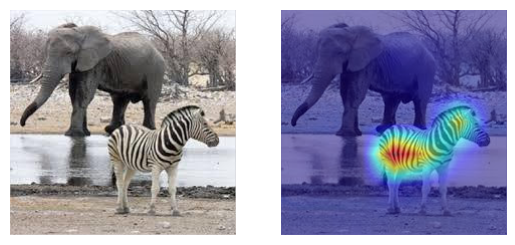

tensor([0.0352, 0.9648], device='cuda:0', dtype=torch.float16)


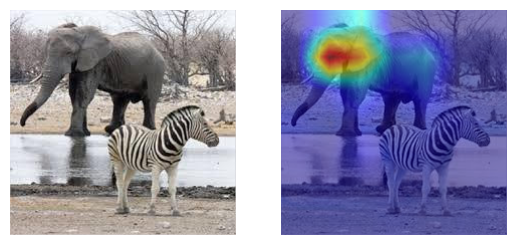

tensor([0.5479, 0.4526], device='cuda:0', dtype=torch.float16)


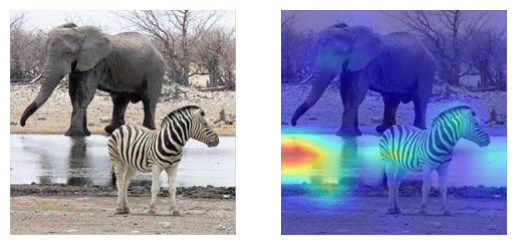

In [13]:
# 图像文件路径
img_path = "CLIP/el2.png"

# 预处理图像并移动到指定设备
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

# 定义要分析的文本
texts = ['a zebra', 'an elephant', 'a lake']

# 使用CLIP的分词函数对文本进行编码并移动到指定设备
text = clip.tokenize(texts).to(device)

# 进行模型解释性分析，获取文本和图像的相关性
R_text, R_image = interpret(model=model, image=img, texts=text, device=device)

# 获取文本的批处理大小
batch_size = text.shape[0]

# 遍历每个样本，显示文本和图像的相关性热图
for i in range(batch_size):
  # 显示文本相关性的热图
  show_heatmap_on_text(texts[i], text[i], R_text[i])

  # 显示图像相关性的热图
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))

  # 显示图像和文本的热图
  plt.show()


tensor([0.1205, 0.8799], device='cuda:0', dtype=torch.float16)


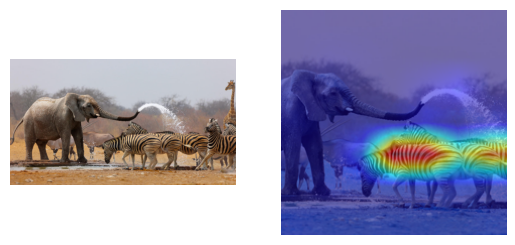

tensor([0.0839, 0.9165], device='cuda:0', dtype=torch.float16)


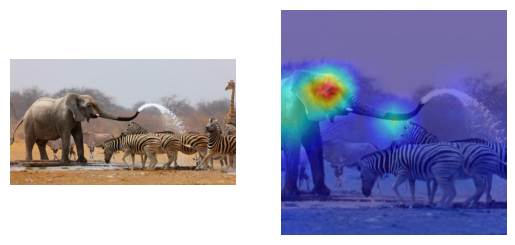

tensor([1.], device='cuda:0', dtype=torch.float16)


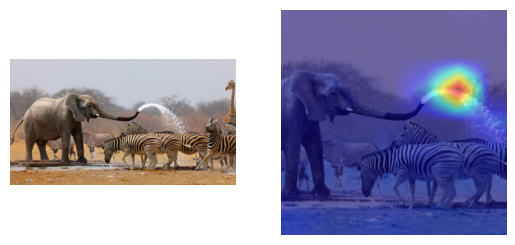

In [14]:
# 图像文件路径
img_path = "CLIP/el3.png"

# 预处理图像并移动到指定设备
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

# 定义要分析的文本
texts = ['a zebra', 'an elephant', 'water']

# 使用CLIP的分词函数对文本进行编码并移动到指定设备
text = clip.tokenize(texts).to(device)

# 进行模型解释性分析，获取文本和图像的相关性
R_text, R_image = interpret(model=model, image=img, texts=text, device=device)

# 获取文本的批处理大小
batch_size = text.shape[0]

# 遍历每个样本，显示文本和图像的相关性热图
for i in range(batch_size):
  # 显示文本相关性的热图
  show_heatmap_on_text(texts[i], text[i], R_text[i])

  # 显示图像相关性的热图
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))

  # 显示图像和文本的热图
  plt.show()


tensor([0.0369, 0.9629], device='cuda:0', dtype=torch.float16)


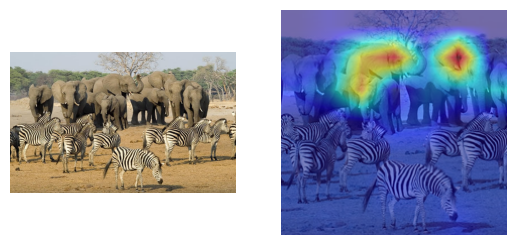

tensor([0.0188, 0.9810], device='cuda:0', dtype=torch.float16)


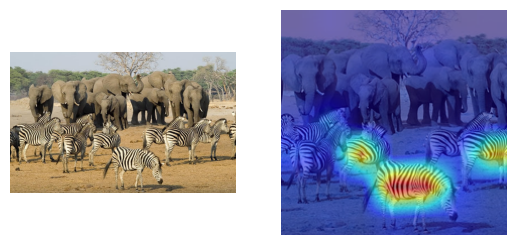

In [15]:
# 图像文件路径
img_path = "CLIP/el4.png"

# 预处理图像并移动到指定设备
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

# 定义要分析的文本
texts = ['an elephant', 'a zebra']

# 使用CLIP的分词函数对文本进行编码并移动到指定设备
text = clip.tokenize(texts).to(device)

# 进行模型解释性分析，获取文本和图像的相关性
R_text, R_image = interpret(model=model, image=img, texts=text, device=device)

# 获取文本的批处理大小
batch_size = text.shape[0]

# 遍历每个样本，显示文本和图像的相关性热图
for i in range(batch_size):
  # 显示文本相关性的热图
  show_heatmap_on_text(texts[i], text[i], R_text[i])

  # 显示图像相关性的热图
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))

  # 显示图像和文本的热图
  plt.show()


tensor([0.0446, 0.9556], device='cuda:0', dtype=torch.float16)


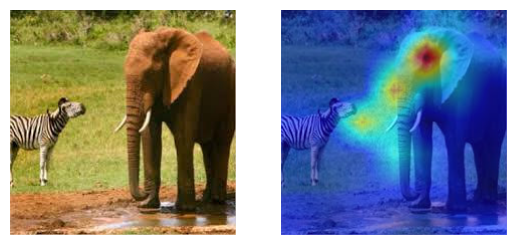

tensor([0.0582, 0.9419], device='cuda:0', dtype=torch.float16)


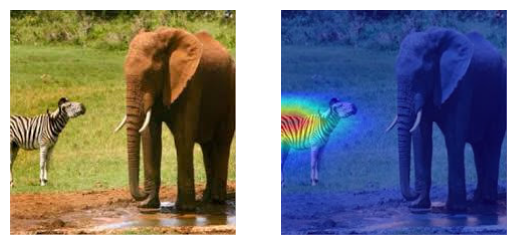

In [16]:
# 图像文件路径
img_path = "CLIP/el1.png"

# 预处理图像并移动到指定设备
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

# 定义要分析的文本
texts = ['an elephant', 'a zebra']

# 使用CLIP的分词函数对文本进行编码并移动到指定设备
text = clip.tokenize(texts).to(device)

# 进行模型解释性分析，获取文本和图像的相关性
R_text, R_image = interpret(model=model, image=img, texts=text, device=device)

# 获取文本的批处理大小
batch_size = text.shape[0]

# 遍历每个样本，显示文本和图像的相关性热图
for i in range(batch_size):
  # 显示文本相关性的热图
  show_heatmap_on_text(texts[i], text[i], R_text[i])

  # 显示图像相关性的热图
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))

  # 显示图像和文本的热图
  plt.show()


tensor([0.0447, 0.9551], device='cuda:0', dtype=torch.float16)


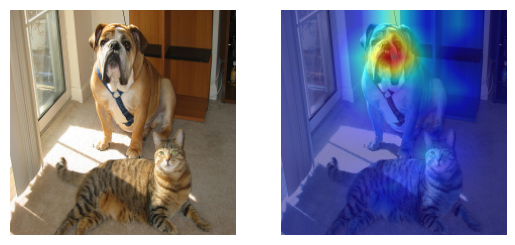

tensor([0.0348, 0.9653], device='cuda:0', dtype=torch.float16)


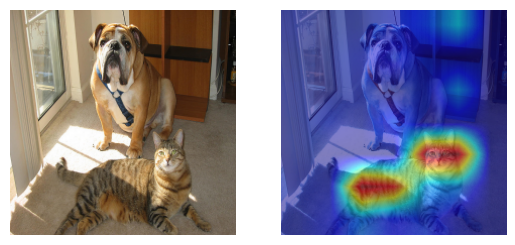

In [17]:
# 图像文件路径
img_path = "CLIP/catdog.png"

# 预处理图像并移动到指定设备
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

# 定义要分析的文本
texts = ["a dog", "a cat"]

# 使用CLIP的分词函数对文本进行编码并移动到指定设备
text = clip.tokenize(texts).to(device)

# 进行模型解释性分析，获取文本和图像的相关性
R_text, R_image = interpret(model=model, image=img, texts=text, device=device)

# 获取文本的批处理大小
batch_size = text.shape[0]

# 遍历每个样本，显示文本和图像的相关性热图
for i in range(batch_size):
  # 显示文本相关性的热图
  show_heatmap_on_text(texts[i], text[i], R_text[i])

  # 显示图像相关性的热图
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))

  # 显示图像和文本的热图
  plt.show()


tensor([0.0237, 0.9766], device='cuda:0', dtype=torch.float16)


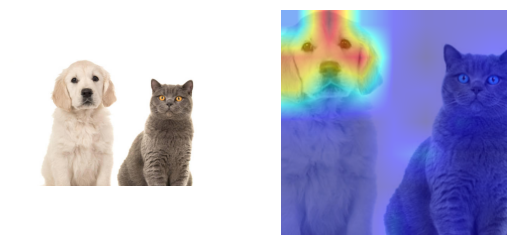

tensor([0.0448, 0.5820, 0.3733], device='cuda:0', dtype=torch.float16)


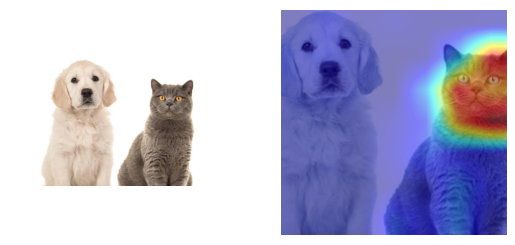

In [18]:
# 图像文件路径
img_path = "CLIP/dogcat2.png"

# 预处理图像并移动到指定设备
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

# 定义要分析的文本
texts = ["a labrador", "a tabby cat"]

# 使用CLIP的分词函数对文本进行编码并移动到指定设备
text = clip.tokenize(texts).to(device)

# 进行模型解释性分析，获取文本和图像的相关性
R_text, R_image = interpret(model=model, image=img, texts=text, device=device)

# 获取文本的批处理大小
batch_size = text.shape[0]

# 遍历每个样本，显示文本和图像的相关性热图
for i in range(batch_size):
  # 显示文本相关性的热图
  show_heatmap_on_text(texts[i], text[i], R_text[i])

  # 显示图像相关性的热图
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))

  # 显示图像和文本的热图
  plt.show()


tensor([0.1221, 0.8774], device='cuda:0', dtype=torch.float16)


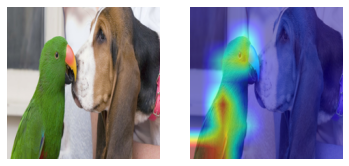

tensor([0.2527, 0.7476], device='cuda:0', dtype=torch.float16)


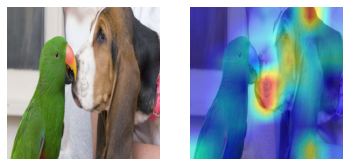

In [ ]:
img_path = "CLIP/dogbird.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["a parrot", "a dog"]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

tensor([0.0726, 0.1309, 0.0593, 0.0403, 0.6973], device='cuda:0',
       dtype=torch.float16)


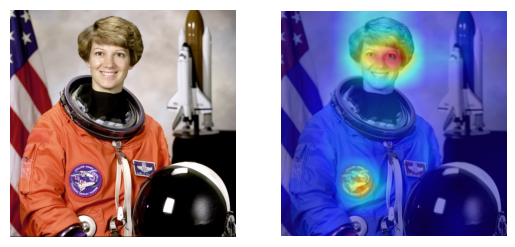

tensor([0.5303, 0.4692], device='cuda:0', dtype=torch.float16)


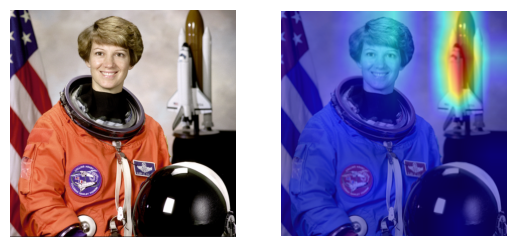

tensor([0.2219, 0.6348, 0.1434], device='cuda:0', dtype=torch.float16)


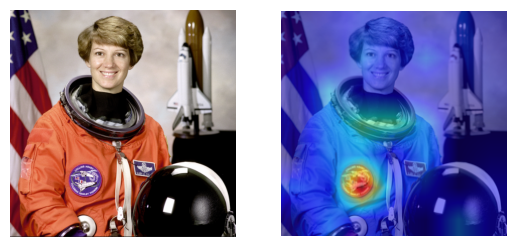

In [19]:
# 图像文件路径
img_path = "CLIP/astronaut.png"

# 预处理图像并移动到指定设备
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

# 定义要分析的文本
texts = ["a portrait of an astronaut", "a rocket", "an astronaut suit"]

# 使用CLIP的分词函数对文本进行编码并移动到指定设备
text = clip.tokenize(texts).to(device)

# 进行模型解释性分析，获取文本和图像的相关性
R_text, R_image = interpret(model=model, image=img, texts=text, device=device)

# 获取文本的批处理大小
batch_size = text.shape[0]

# 遍历每个样本，显示文本和图像的相关性热图
for i in range(batch_size):
  # 显示文本相关性的热图
  show_heatmap_on_text(texts[i], text[i], R_text[i])

  # 显示图像相关性的热图
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))

  # 显示图像和文本的热图
  plt.show()


# Examples of biased similarity scores (noise scores higher than dog)

CLIP 相似性得分: 26.96875
tensor([0.0314, 0.3074, 0.0704, 0.0164, 0.5742], device='cuda:0',
       dtype=torch.float16)


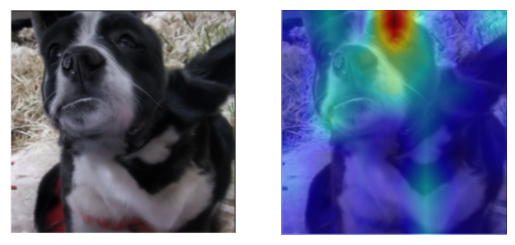

In [20]:
# 图像文件路径
img_path = "CLIP/dog.png"

# 预处理图像并移动到指定设备
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

# 定义要分析的文本
texts = ["an image of a dog"]

# 使用CLIP的分词函数对文本进行编码并移动到指定设备
text = clip.tokenize(texts).to(device)

# 使用CLIP模型计算图像和文本的相似性得分
logits_per_image, logits_per_text = model(img, text)

# 打印 CLIP 相似性得分
print(color.BOLD + color.PURPLE + color.UNDERLINE + f'CLIP 相似性得分: {logits_per_image.item()}' + color.END)

# 进行模型解释性分析，获取文本和图像的相关性
R_text, R_image = interpret(model=model, image=img, texts=text, device=device)

# 获取文本的批处理大小
batch_size = text.shape[0]

# 遍历每个样本，显示文本和图像的相关性热图
for i in range(batch_size):
  # 显示文本相关性的热图
  show_heatmap_on_text(texts[i], text[i], R_text[i])

  # 显示图像相关性的热图
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))

  # 显示图像和文本的热图
  plt.show()


CLIP 相似性得分: 28.71875
tensor([0.0595, 0.3022, 0.4741, 0.0611, 0.1031], device='cuda:0',
       dtype=torch.float16)


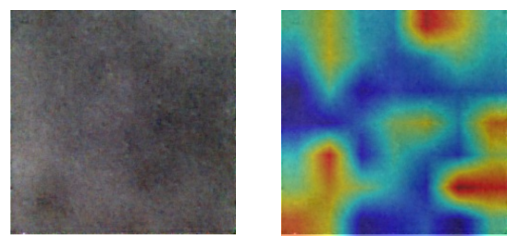

In [23]:
# 图像文件路径
img_path = "CLIP/noise.png"

# 预处理图像并移动到指定设备
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

# 定义要分析的文本
texts = ["an image of a dog"]

# 使用 CLIP 的分词函数对文本进行编码并移动到指定设备
text = clip.tokenize(texts).to(device)

# 使用 CLIP 模型计算图像和文本的相似性得分
logits_per_image, logits_per_text = model(img, text)

# 打印 CLIP 相似性得分
print(color.BOLD + color.PURPLE + color.UNDERLINE + f'CLIP 相似性得分: {logits_per_image.item()}' + color.END)

# 进行模型解释性分析，获取文本和图像的相关性
R_text, R_image = interpret(model=model, image=img, texts=text, device=device)

# 获取文本的批处理大小
batch_size = text.shape[0]

# 遍历每个样本，显示文本和图像的相关性热图
for i in range(batch_size):
  # 显示文本相关性的热图
  show_heatmap_on_text(texts[i], text[i], R_text[i])

  # 显示图像相关性的热图
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))

  # 显示图像和文本的热图
  plt.show()


CLIP 相似性得分: 26.96875


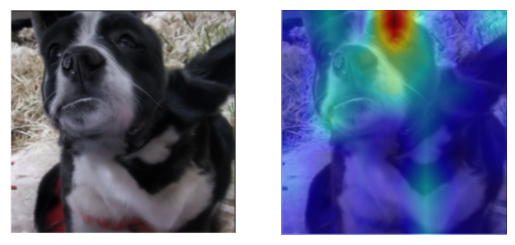

In [25]:
import torch
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from captum.attr import visualization
from CLIP.clip.simple_tokenizer import SimpleTokenizer
from einops import rearrange

# 创建 CLIP 模型和预处理器
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

# 创建 CLIP 模型的分词器
_tokenizer = SimpleTokenizer()

def generate_heatmap(image_path, texts):
    # 预处理图像并移动到指定设备
    img = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

    # 使用 CLIP 的分词器对文本进行编码并移动到指定设备
    text = clip.tokenize(texts).to(device)

    # 使用 CLIP 模型计算图像和文本的相似性得分
    logits_per_image, _ = model(img, text)

    # 进行模型解释性分析，获取文本和图像的相关性
    R_text, R_image = interpret(model=model, image=img, texts=text, device=device)

    # 打印 CLIP 相似性得分
    print(color.BOLD + color.PURPLE + color.UNDERLINE + f'CLIP 相似性得分: {logits_per_image.item()}' + color.END)

    # 获取文本的批处理大小
    batch_size = text.shape[0]

    # 遍历每个样本，显示文本和图像的相关性热图
    for i in range(batch_size):
        # 显示文本相关性的热图
        show_heatmap_on_text(texts[i], text[i], R_text[i])

        # 显示图像相关性的热图
        show_image_relevance(R_image[i], img, orig_image=Image.open(image_path))

        # 显示图像和文本的热图
        plt.show()

def show_heatmap_on_text(text, text_encoding, R_text):
    CLS_idx = text_encoding.argmax(dim=-1)
    R_text = R_text[CLS_idx, 1:CLS_idx]
    text_scores = R_text / R_text.sum()
    text_scores = text_scores.flatten()
    text_tokens = _tokenizer.encode(text)
    text_tokens_decoded = [_tokenizer.decode([a]) for a in text_tokens]
    vis_data_records = [visualization.VisualizationDataRecord(text_scores, 0, 0, 0, 0, 0, text_tokens_decoded, 1)]
    visualization.visualize_text(vis_data_records)

def show_image_relevance(image_relevance, image, orig_image):
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image);
    axs[0].axis('off');

    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs[1].imshow(vis);
    axs[1].axis('off');

# 使用例子
image_path_example = "CLIP/dog.png"
texts_example = ["an image of a dog"]
generate_heatmap(image_path_example, texts_example)


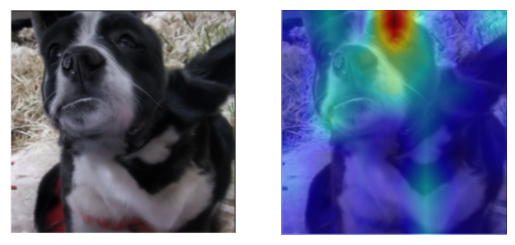

In [27]:
import torch
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from captum.attr import visualization
# from CLIP.clip.simple_tokenizer import SimpleTokenizer
from einops import rearrange

def show_heatmap(image_path, texts):
    # 预处理图像并转换为指定格式
    img = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

    # 使用 CLIP 的分词器对文本进行编码并转换为指定格式
    text = clip.tokenize(texts).to(device)

    # 进行模型解释性分析，获取文本和图像的相关性
    R_text, R_image = interpret(model=model, image=img, texts=text, device=device)

    # 获取文本的批处理大小
    batch_size = text.shape[0]

    # 遍历每个样本，显示文本和图像的相关性热图
    for i in range(batch_size):
        # 显示文本相关性的热图
        show_heatmap_on_text(texts[i], text[i], R_text[i])

        # 显示图像相关性的热图
        show_image_relevance(R_image[i], img, orig_image=Image.open(image_path))

        # 显示图像和文本的热图
        plt.show()

# 使用例子
image_path_example = "CLIP/dog.png"
texts_example = ["an image of a dog"]
show_heatmap(image_path_example, texts_example)
